In [133]:
import os
import random

from netpyne import specs, sim
%matplotlib inline


folder = 'Ground truth SWCs'
cells = 50

netParams = specs.NetParams()
netParams.sizeX = 600             # x-dimension (horizontal length) size in um
netParams.sizeY = 600            # y-dimension (vertical height or cortical depth) size in um
netParams.sizeZ = 100
netParams.propVelocity = 5.0    # propagation velocity (um/ms)
netParams.probLengthConst = 100.0 


swc_filenames = []
for file in os.listdir(folder):
    if os.path.splitext(file)[-1] == '.swc':
        swc_filenames.append(file)

print(swc_filenames)
num_pops = len(swc_filenames)

cell_labels = []
for ii, swc_fname in enumerate(swc_filenames):
    label = f'swc_{ii:04d}'
    
    cellRule = netParams.importCellParams(
        label=label, 
        conds={'cellType': 'PYR'},
        fileName=os.path.join(folder, swc_fname), 
        cellName='swc_fname',
        )
    
    cell_labels.append(label)
    
    # For convenience, we'll rename the first soma section in the morphology from `soma_0` to `soma`.
    netParams.renameCellParamsSec(label, 'soma_0', 'soma')
    

    for secName in cellRule['secs']:
        cellRule['secs'][secName]['geom']['cm'] = 1
        if secName.startswith('soma'):
            cellRule['secs'][secName]['mechs']['hh'] = {
                'gnabar': 0.12, 
                'gkbar': 0.036, 
                'gl': 0.003, 
                'el': -70,
                }
        else:
            cellRule['secs'][secName]['mechs']['hh'] = {
                'gnabar': 0.12, 
                'gkbar': 0.036, 
                'gl': 0.003, 
                'el': -70,
                }
        
    # Now we'll make a population out of our imported cell.
    # netParams.popParams[ii] = {'cellType': 'swc_cell', 'numCells': 1}

    netParams.popParams[label] = {'cellType': 'PYR',
                                  'numCells': int(cells/num_pops)}

['Image10.rnp.swc', 'Image31.rnp.swc', 'Image4.rnp.swc', 'Image5.rnp.swc', 'Image7.rnp.swc', 'Series17.rnp.swc', 'Series19.rnp.swc', 'Series21.rnp.swc', 'Series9.rnp.swc']


In [134]:
## Synaptic mechanism parameters
netParams.synMechParams['exc'] = {'mod': 'Exp2Syn', 'tau1': 0.8, 'tau2': 5.3, 'e': 0}  # NMDA synaptic mechanism
netParams.synMechParams['inh'] = {'mod': 'Exp2Syn', 'tau1': 0.6, 'tau2': 8.5, 'e': -75}  # GABA synaptic mechanism

# Stimulation parameters
netParams.stimSourceParams['bkg'] = {'type': 'NetStim', 'rate': 20, 'noise': 0.3}
netParams.stimTargetParams['bkg->all'] = {'source': 'bkg', 'conds': {'cellType': 'PYR'}, 'weight': 0.01, 'delay': 'max(1, normal(5,2))', 'synMech': 'exc'}

stim_ii = random.randint(0, cells-1)
print(f'Cell # {stim_ii} is stimulated')

netParams.stimSourceParams['Probe'] = {'type': 'NetStim', 'rate': 10}
netParams.stimTargetParams['Probe->Cell'] = {'source': 'Probe', 'conds': {'cellList': [stim_ii]}, 'weight': 0.5, 'delay': '30', 'synMech': 'exc'}

Cell # 14 is stimulated


In [135]:
# Distance-based connectivity
netParams.connParams['all-E->all'] = {
    'preConds': {'cellType': 'PYR'}, 
    'postConds': {'cellType': 'PYR'},  #  E -> all (100-1000 um)
    'probability': '1*exp(-dist_3D/probLengthConst)',                  # probability of connection
    'weight': '0.60',         # synaptic weight
    'delay': 'dist_3D/propVelocity',      # transmission delay (ms)
    'synMech': 'exc'}                     # synaptic mechanism

netParams.connParams['all-I->all'] = {
    'preConds': {'cellType': 'PYR'}, 
    'postConds': {'cellType': 'PYR'},  #  E -> all (100-1000 um)
    'probability': '0.1*exp(-dist_3D/probLengthConst)',                  # probability of connection
    'weight': '0.01',         # synaptic weight
    'delay': 'dist_3D/propVelocity',      # transmission delay (ms)
    'synMech': 'inh'}                     # synaptic mechanism


Start time:  2022-05-17 17:35:37.137081

Creating network of 9 cell populations on 1 hosts...
  Number of cells on node 0: 45 
  Done; cell creation time = 28.71 s.
Making connections...
  Number of connections on node 0: 207 
  Number of synaptic contacts on node 0: 229 
  Done; cell connection time = 0.06 s.
Adding stims...
  Number of stims on node 0: 46 
  Done; cell stims creation time = 0.00 s.
Recording 45 traces of 1 types on node 0

Running simulation using NEURON for 400.0 ms...
  Done; run time = 9.46 s; real-time ratio: 0.04.

Gathering data...
  Done; gather time = 0.99 s.

Analyzing...
  Cells: 45
  Connections: 252 (5.60 per cell)
  Synaptic contacts: 275 (6.11 per cell)
  Spikes: 235 (13.06 Hz)
  Simulated time: 0.4 s; 1 workers
  Run time: 9.46 s
Saving output as tut5_data.pkl ... 
Finished saving!
  Done; saving time = 8.50 s.
Preparing spike data...
Plotting raster...
Plotting recorded cell traces ... cell


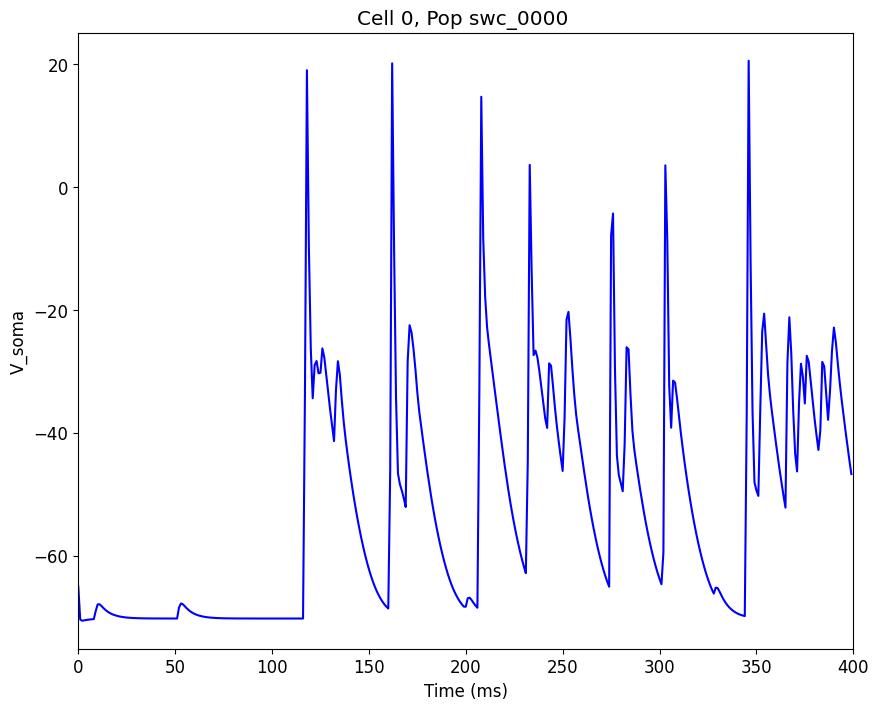

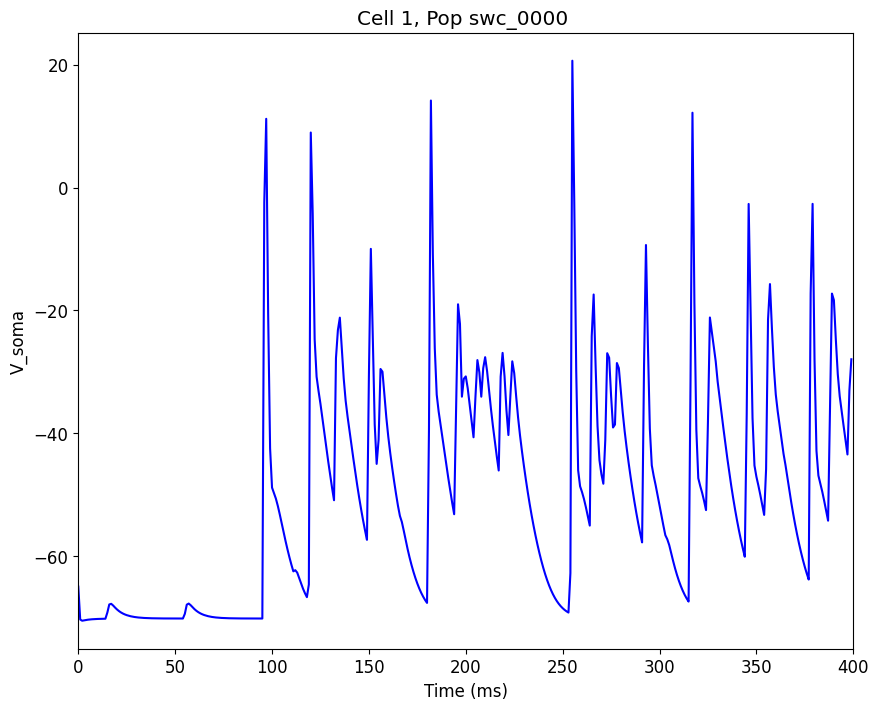

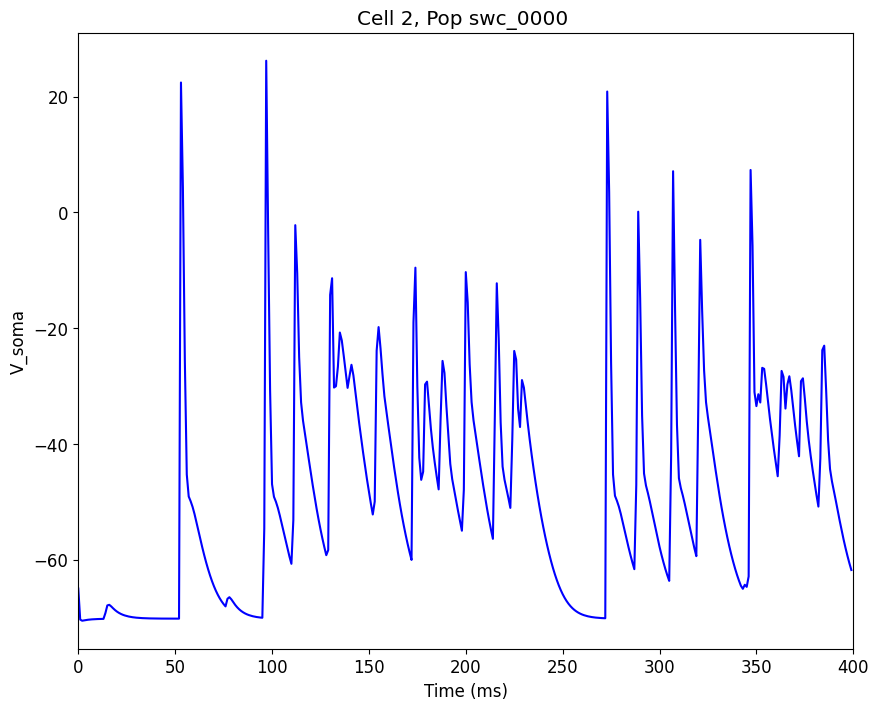

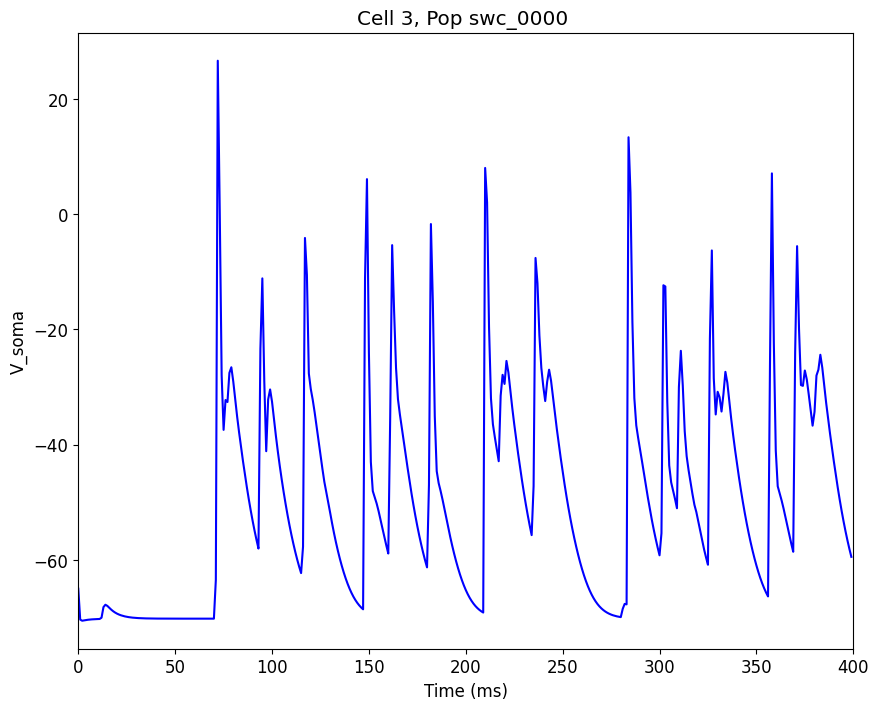

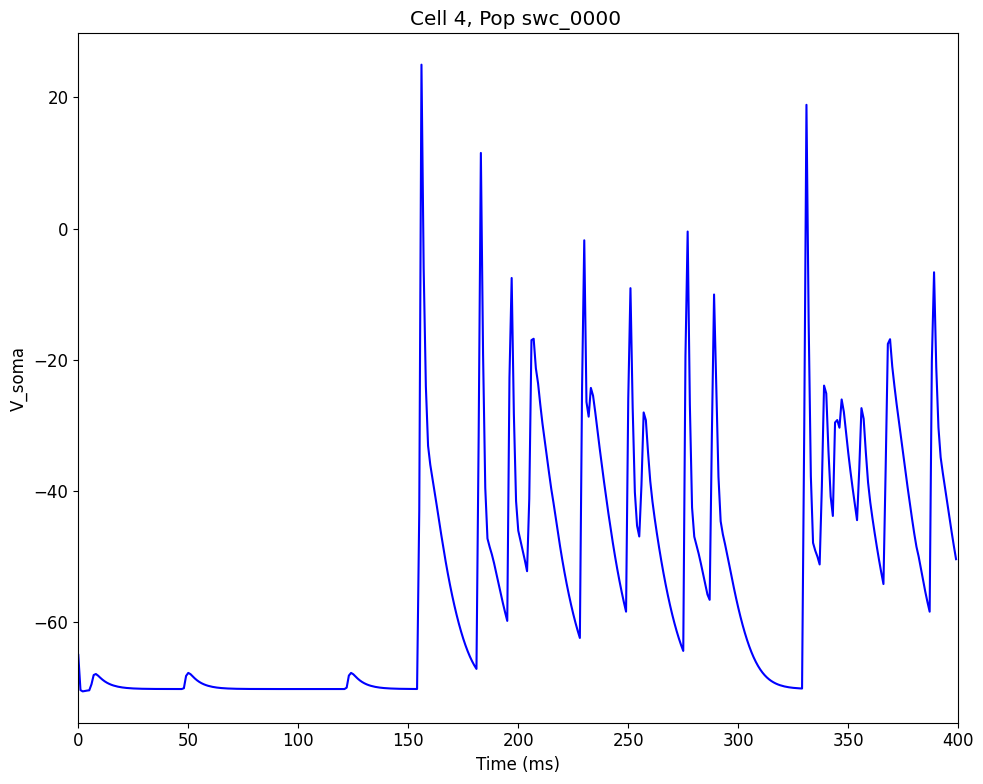

Plotting 2D representation of network cell locations and connections...


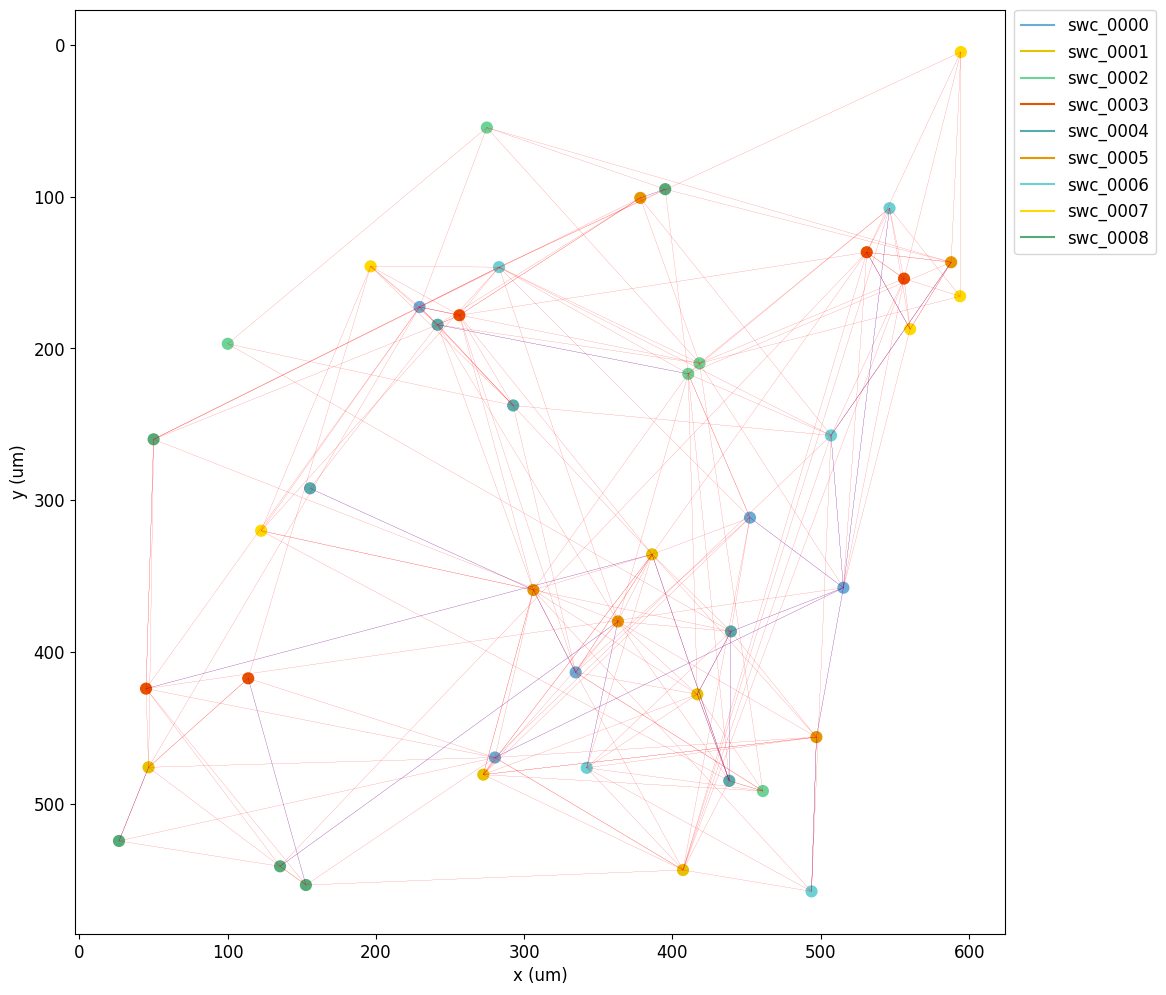

Plotting connectivity matrix...


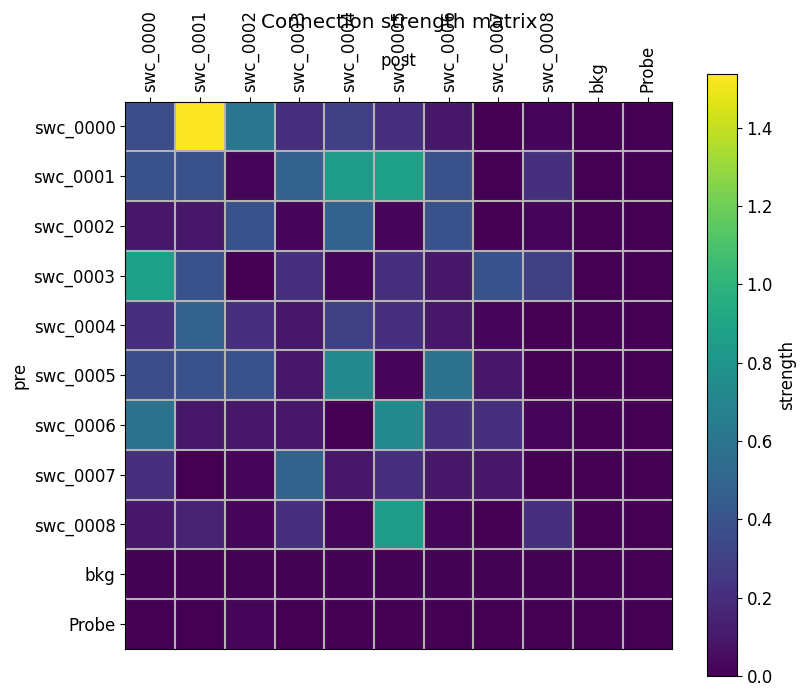

  Done; plotting time = 1.93 s

Total time = 49.68 s


In [136]:
# Simulation options
simConfig = specs.SimConfig()        # object of class SimConfig to store simulation configuration

simConfig.duration = 0.4*1e3           # Duration of the simulation, in ms
simConfig.dt = 0.05                  # Internal integration timestep to use
simConfig.verbose = False            # Show detailed messages
simConfig.recordTraces = {'V_soma':{'sec':'soma','loc':0.5,'var':'v'}}  # Dict with traces to record
simConfig.recordCells = range(cells)
simConfig.recordStep = 1             # Step size in ms to save data (e.g. V traces, LFP, etc)
simConfig.filename = 'tut5'          # Set file output name
simConfig.savePickle = True         # Save params, network and sim output to pickle file

simConfig.analysis['plotRaster'] = {'orderBy': 'y', 'orderInverse': True, 'saveFig': True}         # Plot a raster
simConfig.analysis['plotTraces'] = {'include': [cell_labels[0]], 'saveFig': True}  # Plot recorded traces for this list of cells
simConfig.analysis['plot2Dnet'] = {'saveFig': True}                                                # plot 2D cell positions and connections
simConfig.analysis['plotConn'] = {'saveFig': True}                                                 # plot connectivity matrix

# Create network and run simulation
sim.createSimulateAnalyze(netParams = netParams, simConfig = simConfig)

In [137]:
import matplotlib.pyplot as plt
import numpy as np

Text(0, 0.5, 'Neuron #')

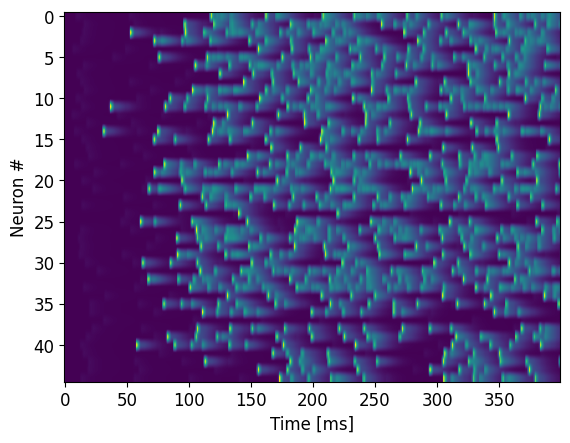

In [138]:
data = []
for key, value in sim.simData['V_soma'].items():
    if key[0] is not '_':
        data.append(list(value))
        
data = np.array(data)

plt.imshow(data, aspect='auto', interpolation=None)
plt.xlabel('Time [ms]')
plt.ylabel('Neuron #')